#Chapter 2. Variable Attribution for Multivariate, Multimodal Anomaly Detection with Interpretability

For a Detailed discussion please refer to [Interpretable, Multidimensional, Multimodal Anomaly Detection with Negative Sampling](https://proceedings.icml.cc/static/paper_files/icml/2020/2557-Paper.pdf) (2020).

In practice, knowing which dimensions caused an anomaly score helps the user identify the root cause and choose an appropriate fix. In climate control devices, dimensions like zone temperature, carbon dioxide level, humidity, etc., are codependent. Highlighting a single anomalous dimension
usually identifies a broken sensor, whereas identifying multiple dimensions helps pinpoint a mechanical failure caused by a defective valve, stuck damper, etc. As a first step in anomaly interpretation, we would like to quantify a pro-
portional blame for each dimension.

Recent work on deep network model interpretability can be applied to variable attribution. For example, Integrated Gradients [(Sundararajan et al., 2017](https://arxiv.org/pdf/1703.01365.pdf)), have been shown to indicate what pixels contributed most to an image classification, or what words contributed to a text classification. The Integrated Gradients method computes and integrates the gradient for each dimension from a neutral baseline point to the observed point.

In the image classification task, a black image is commonly used as the neutral baseline, and in the text classification task, a zero-embedding token vector is suitable. However, in anomaly interpretation the neutral baseline is not immedi-
ately obvious. We fundamentally would like to know, given an anomalous point x, how to transform $x$ into a suitable normal point $u^{∗}$. For example, if the thermostat is generating anomalous data while in eco-mode, we would like to
understand which dimensions must be altered to transform the anomalous point to a normal point in eco-mode, rather than in a more remote comfort mode.

***Perform variable attribution with Integrated Gradients***, after loading data and training an NS-NN Anomaly Detector, the first step creates sliders for each dimension. The output of that cell should be pasted into the following cell, as marked. Then you can perturb the original Normal state by moving one or more sliders. You will see a pie chart, where the center is the anomaly score $P(x \in Normal)$ and the wedges of the pie are the blame for each dimension $B_{d}(x)/\sum B_{d}(x)$ with the observed value $x_{d}$ and the nearest baseline value  $u_{d}^{*}$ for all dimensions $d:B_{d}(x) \geq 0.05$. The chart below shows individual blames $B_{d}(x)$ vs. $\alpha \in [0,1]$ with 2,000 steps from $u^{*}$ to $x$.

##Quickstart
Simply execute the following cell that performs a pip-install of madi from the github repo.




In [ ]:
!pip install git+https://github.com/google/madi.git

In [1]:
#@title Colab Imports
import sys
import madi
from madi.utils import file_utils
import numpy as np
import pandas as pd
from typing import List, Dict
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib as mpl
import seaborn as sns

from madi.datasets import smart_buildings_dataset
from madi.detectors.neg_sample_neural_net_detector import NegativeSamplingNeuralNetworkAD
from madi.detectors.integrated_gradients_interpreter import IntegratedGradientsInterpreter

import tensorflow as tf
assert tf.version.VERSION > '2.1.0'

In [2]:
#@title Plotting utilities
def plot_attribution(df_attribution: pd.DataFrame, anomaly_score: float) -> None:
  """Plots the attribution as a pie chart.

  The center contains the anmomaly score. The wedges are ordered clockwise
  from the most blame to the least. The percentages are the normalized
  percentages (Blame(d) / Sum of Blames). The values outside the wedges
  indicate the observed value, and the expected value in parentheses.

  Args:
    df_attribution: dataframe with observed_value, expected_value, and
    attribution for each dimension.
    anomaly_score: score ranging between Normal (1) and Anomalous (0).

  """
  df_attribution = df_attribution.sort_values(by='attribution', ascending=False)
  norm = plt.Normalize()
  names=[]
  sizes = []
  sum_big = 0
  for fn, row in df_attribution.iterrows():
    # Only show the dimensions with a blame > 5%.
    if row.attribution > 0.05:
      names.append('%s\n%3.1f (%3.1f)' %(fn, row.observed_value, row.expected_value))
      wedge_size = int(100* row.attribution)
      sum_big += wedge_size
      sizes.append(wedge_size)
  names.append('other')
  sizes.append(int(100 - sum_big))

  # Create a circle for the center of the plot
  num_p_score_steps = 100
  center_color_index  = int(num_p_score_steps*anomaly_score)
  my_circle=plt.Circle( (0,0), 0.45, facecolor=plt.cm.RdYlGn(
      norm(range(num_p_score_steps+1)))[center_color_index],
      edgecolor='white', linewidth=3)

  fig, ax = plt.subplots()
  fig.set_figheight(10)
  fig.set_figwidth(10)

  center_text = "%.2f" %(anomaly_score)
  if (center_color_index < 20 ) or (center_color_index > 80):
    text_color = 'white'
  else:
    text_color = 'black'
  ax.text(0,0,center_text, fontsize=28,horizontalalignment='center',
          color=text_color, weight="bold")

  # Custom colors --> colors will cycle
  norm = plt.Normalize()
  # Choose nine colors to cycle through to show contrast between slices.
  pie_plot = plt.pie(sizes, labels=names, colors=plt.cm.RdYlBu(norm(range(9)), alpha=0.6),
                     startangle=90, counterclock=False, autopct='%1.0f%%',
                     pctdistance=0.70, textprops=
                     dict(color="black", weight="bold", fontsize=28))

  for lab in pie_plot[1]:
    lab.set_fontsize(28)
  p=plt.gcf()
  p.gca().add_artist(my_circle)
  plt.show()

def plot_gradient_series(df_grad: pd.DataFrame, delta: np.array) -> None:
    fig, ax = plt.subplots()
    fig.set_figheight(12)
    fig.set_figwidth(15)
    n_points = len(df_grad)
    colors = sns.color_palette('rainbow', df_grad.shape[1])
    for ix, field_name in enumerate(df_grad):
      series_color = colors[ix]
      ig_series = (df_grad[field_name].cumsum()/float(n_points)) * delta[field_name]
      ax.plot(df_grad.index, ig_series , linewidth=3.0, linestyle='-', marker=None, color=series_color)

    ax.grid(linestyle='-', linewidth='0.5', color='darkgray')

    legend = plt.legend(loc='upper left', shadow=False, fontsize='16', bbox_to_anchor=(1, 1), labels = list(df_grad))
    legend.get_frame().set_facecolor('white')
    plt.ylabel('Cumulative Gradients')

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
      item.set_fontsize(24)

    for sp in ax.spines:
       ax.spines[sp].set_color("black")
    ax.set_facecolor("white")

    plt.grid(True)
    plt.show()

##1. Load up a positive sample dataset.
The input data is loaded into a Pandas DataFrame must meet the following criteria:

*   Two or more real- or integer-valued feature columns.
*   No null values.
*   No categorical values.
*   A sample size of at least a few thousand rows.



---

Two example datasets are provided (more coming soon!):


A **Gaussian Mixture** with two spherical gaussian modes in 16 dimensions, with 5% contamination.

The **Smart Buildings Dataset**.

To create your own dataset, simply implement your custom [`madi.datasets.basedataset.BaseDataset`](https://cs.corp.google.com/piper///depot/google3/third_party/py/madi/datasets/base_dataset.py?g=0) and provide a name, description and Pandas DataFrame that meets the criteria above.


When everything is loaded, you should see info about the training set size and the test set size.



In [3]:
#@title Choose the data set
_RESOURCE_LOCATION = "madi.datasets.data"
data_source = "smart_buildings" #@param ["gaussian_mixture", "smart_buildings"]
ds = None

class InvalidDatasetError(ValueError):
    pass

if data_source == 'gaussian_mixture':
  contamination = 0.15

  ds = gaussian_mixture_dataset.GaussianMixtureDataset(
          n_dim=16,
          n_modes=2,
          n_pts_pos=8000,
          sample_ratio=contamination,
          upper_bound=3,
          lower_bound=-3)

  print('Loaded Gaussian mixture with 2 modes in 16 dimensions, with a sample size of %d.' %len(ds.sample))

elif data_source == 'smart_buildings':
  data_file = file_utils.PackageResource(
      _RESOURCE_LOCATION, "anomaly_detection_sample_1577622599.csv")
  readme_file = file_utils.PackageResource(
      _RESOURCE_LOCATION, "anomaly_detection_sample_1577622599_README.md")
  ds = madi.datasets.smart_buildings_dataset.SmartBuildingsDataset(data_file, readme_file)
  print(ds.description)

else:
  raise InvalidDatasetError("You requested an invalid data set (%s)." %data_source)


print('Randomize the data, and split into training and test sample.')
split_ix = int(len(ds.sample) * 0.8)
training_sample = ds.sample.iloc[:split_ix]
test_sample = ds.sample.iloc[split_ix:]
print("\tTraining sample size: %d" %len(training_sample))
print("\tTest sample size: %d" %len(test_sample))

The Smart Buildings Anomaly Detection dataset consists of 60,425
 multidimensional, multimodal observations derived from 15
 Variable Air Volume (VAV) climate control devices collected over 14 days
 between October 8 and October 21, 2019, from a Google campus in the
 California Bay Area. In 1,921 (3.2%) anomalous observations, the devices
 are unable to maintain setpoint, and are of interest to facilities
 technicians. A setpoint is maintained when the zone air temperature
 remains above the zone air heating setpoint, and below the zone air
 cooling setpoint. On Mondays through Fridays, from 6:00 am to 10:00 pm
 local time, the devices operate in a comfort mode, with tight constraints
 between the heating and cooling setpoints. From 10:00 pm to 6:00 am, and
 on weekends the setpoints are wider to reduce energy consumption, and
 hence, there are comfort and eco operating modes. The data had seven
 numeric dimensions: zone air cooling temperature setpoint, zone air
 heating temperature s

##2. Train a Negative-Sample Neural Network (NS-NN)
Here we set the parameters and train a NS-NN anomaly detector discussed in Section 3.1. The NS-NN first generates a negative sample representing the anomalous class, and produces a labled dataset with the observed sample as the positive dataset representing the normal class. Then it trains a simple binary classifier to distinguish between normal and anomalous classes.

In [4]:
#@title Train a Negative Sampling Neural Net (NS-NN) Anomaly Detector
log_dir = "logs/nsnn2" #@param {type:"string"}

nsnn_params = {}
if data_source == 'gaussian_mixture':

    nsnn_params['sample_ratio']=10.0
    nsnn_params['sample_delta']=0.05
    nsnn_params['batch_size']=16
    nsnn_params['steps_per_epoch']=80
    nsnn_params['epochs']=180
    nsnn_params['dropout']=0.7
    nsnn_params['layer_width']=145
    nsnn_params['n_hidden_layers']=3

elif data_source == 'smart_buildings':
    nsnn_params['sample_ratio']=25.0
    nsnn_params['sample_delta']=0.05
    nsnn_params['batch_size']=32
    nsnn_params['steps_per_epoch']=16
    nsnn_params['epochs']=88
    nsnn_params['dropout']=0.5
    nsnn_params['layer_width']=128
    nsnn_params['n_hidden_layers']=2

else:
  raise InvalidDatasetError("You requested an invalid data set (%s)." %data_source)

print(nsnn_params)
X_train = training_sample.drop(columns = ['class_label'])

# It's very important to normalize the data for both classification and
# anomaly detection.
y_train = training_sample['class_label']

# We shall reuse the normalization info from training for test.
X_test = test_sample.drop(columns = ['class_label'])
y_test= test_sample['class_label']

# Declare the AD and parameterize it.
ad = NegativeSamplingNeuralNetworkAD(
        sample_ratio=nsnn_params['sample_ratio'],
        sample_delta=nsnn_params['sample_delta'],
        batch_size=nsnn_params['batch_size'],
        steps_per_epoch=nsnn_params['steps_per_epoch'],
        epochs=nsnn_params['epochs'],
        dropout=nsnn_params['dropout'],
        layer_width=nsnn_params['layer_width'],
        n_hidden_layers=nsnn_params['n_hidden_layers'],
        log_dir=log_dir)

# Build the sample and train the AD classifier model.
ad.train_model(x_train=X_train)

xy_predicted = ad.predict(X_test)

auc = madi.utils.evaluation_utils.compute_auc(
      y_actual=y_test, y_predicted=xy_predicted['class_prob'])

print("The AUC against the test set is %0.3f" %auc)

{'sample_ratio': 25.0, 'sample_delta': 0.05, 'batch_size': 32, 'steps_per_epoch': 16, 'epochs': 88, 'dropout': 0.5, 'layer_width': 128, 'n_hidden_layers': 2}
1/1 [==============================] - 0s 70ms/step
The AUC against the test set is 0.810


##3. Set up the Anomaly Interpreter

*“**A key step in applying Integrated Gradients is to select
a good baseline**”* (Sundararajan et al., 2017), so we first
discuss how to choose a baseline, and then describe how to
use Integrated Gradients for anomaly interpretation.


**Proposition 3.** (Baseline Set for Anomaly Detection) *Points
from the positive sample used to train the anomaly detection
classifier with high Normal class confidence scores,*  $U^{*}  \subset U : \forall_{u \in U^{*}} F \left ( x \right ) \geq 1 - \epsilon$ *are a sufficient baseline set.*



In the original formulation of Integrated Gradients, $x$ has a high class-confidence score, which requires a baseline point that yields a near-zero class confidence score. In anomaly interpretation it is reversed; since $x$ is an anomaly, $F(x) \approx 0$, the baseline point must be from from the Normal set, $F(u) \approx 1$. By Assumption 1, the positive sample is sufficient and stable. A trained classifier will assign highest Normal class scores to points from regions with the greatest difference in positive and negative sample densities. Tolerance $\epsilon$ depends on the classifier and data, but should be large enough to accumulate enough points to cover all high-confidence Normal regions. Since a uniform distribution guarantees a constant negative sample density, these highest scoring points in $U^{*}$ are in regions with the maximum density of Normal observations.

Once we have established the neutral baseline set, we then determine how to apply it to any anomalous point. To simplify interpretability, we will choose the one nearest point from $U^{*}$ to anomalous point $x$ as an approximation for the closest point on the surface of the Normal volume.  Since integrated gradients computes the gradient along the straight-line path between the point and the baseline, we chose the chose the baseline point from $U^{*}$ with the minimum Euclidean distance $d$, $u^{*}=argmin_{u \in U^{*}} \left \{ d \left ( x, u \right ) \right \}$.  (Using the Euclidean distance assumes a Euclidean space, which requires first normalizing all dimensions.) Along with the proportional blame provided by Integrated Gradients, we have found that the values of $u^{*}$ provide useful interpretation as expected values of the nearest normal.

Now that we have a baseline point for each anomaly, we can apply the Integrated Gradients equation  (below) to assign a proportional blame, $B_{d} \left ( x \right )$ along the $d^{th}$ dimension for anomaly $x$ and nearest normal baseline $u^{*}$, where $\frac{\partial F \left ( x \right )}{\partial x_{d}}$ is the gradient of the anomaly classifier function $F$, and $\alpha$ is path variable that ranges from 0 at $x$ to 1 at $u^{*}$.

$$B_{d}\left (x \right ) \equiv  \left (u_{d}^{*} - x_{d} \right ) \times \int_{\alpha=0}^{1} \frac{\partial F \left ( x + \alpha \times \left (u^{*}-x \right ) \right )}{\partial x_{d}}d \alpha$$

The **Completeness Axiom of Integrated Gradients** ensures that each dimension is assigned a proportional blame and the sum of the blame across each dimension is bounded by tolerance $\epsilon$ and very close to $1$: $1-\sum_{d \in D} B_{d} \left ( x \right ) \leq \epsilon$.

If we assume the cost for computing the distance and gradient are both constant, then the run-time complexity for applying Integrated Gradients for variable attribution is linear with (a) the number of baseline points $\left | U^{*} \right |$, and (b) the number of $k$ steps to compute the gradient along the path variable $\alpha$ from anomaly $x$ to the nearest baseline point $u^{*}$, $O \left ( \left  | U^{*} \right | \right ) + O \left ( k \right )$.

Putting it all together, this approach is an anomaly detector with a novel method of interpreting the anomaly.  Propositions 1 and 2 describe a method of creating a labeled data set to train an anomaly detection classifier, and Proposition 3 proposes a way of applying Integrated Gradients and a deep network anomaly classifier to interpret an anomaly score. In the following section we will demonstrate the performance compared to other anomaly detection methods with various data sets.

---

Below, select the `minimum classifier confidence` $F(x)$ for the baseline set, and the maximum size of the baseline. If there are more than the maximum specifed size, we'll just choose the highest scoring points.


If you select a value too high for the minimum classifier confidence, the baseline will be empty and will generate an error. To fix that problem, either lower the confidence threshold as specified, or go back to Step 2 and train a new model with different parameters.


**Hint:** If the max confidence drops well below 0.95), you should train a new model.

In [5]:
#@title Set up the anomaly interpreter.


min_class_confidence = 0.99 #@param {type:"number"}
max_baseline_size = 500 #@param {type:"integer"}

try:
  X_train_normalized = madi.utils.sample_utils.normalize(X_train, ad._normalization_info)
  interpreter = madi.detectors.integrated_gradients_interpreter.IntegratedGradientsInterpreter(
          ad._model, X_train_normalized,
          min_class_confidence, max_baseline_size,num_steps_integrated_gradients = 2000)
  print('Variable Attibution is ready with a baseline sample size of %d points.' %len(interpreter._df_baseline))
except madi.detectors.integrated_gradients_interpreter.NoQualifyingBaselineError as err:
  print(err.message)
  print('Assign min_class_confidence to a value below %0.2f to accumulate a baseline sample.' %err.highest_class_confidence)
  print('Variable Attibution is NOT ready.')

1/1 [==============================] - 0s 80ms/step
Variable Attibution is ready with a baseline sample size of 500 points.


In [6]:
#@title Generate the sliders for interactive control.

def get_variable_slider(variable_name:str, mean:float, std:float, default:float) -> str:
  if "percent" in variable_name:
    min_val = 0
    max_val = 100
    step = 1
  elif "temperature" in variable_name:
    min_val = 250
    max_val = 350
    step = 1
  elif variable_name == "dow":
    min_val = 0
    max_val = 6
    step = 1
  elif variable_name == "hod":
    min_val = 0
    max_val = 23
    step = 1
  else:
    min_val = mean - 6 * std
    max_val = mean + 6 * std
    step = (max_val - min_val)/100.0

  var_name_base = variable_name.replace("data:", "")
  return """%s = %f #%sparam {type:"slider", min:%f, max:%f, step:%f}""" %(var_name_base, default, "@", min_val, max_val, step )

def get_var_assignment(variable_name: str) -> str:
  var_name_base = variable_name.replace("data:", "")
  return """observed_point['%s'] = [%s]""" %(variable_name, var_name_base)

def get_sliders(normalization_info: Dict[str, madi.utils.sample_utils.Variable], baseline: pd.DataFrame):
  column_order = madi.utils.sample_utils.get_column_order(normalization_info)
  slider_strings  = []
  for col in column_order:
    slider_strings.append(get_variable_slider(col, normalization_info[col].mean, normalization_info[col].std, baseline[col]))
  return "\n".join(slider_strings)

def get_var_assignments(normalization_info):
  column_order = madi.utils.sample_utils.get_column_order(normalization_info)
  assignment_strings  = []
  for col in column_order:
    assignment_strings.append(get_var_assignment(normalization_info[col].name))
  return "\n".join(assignment_strings)

df_reference_point_selected_normalized = interpreter._df_baseline.iloc[[0]]
df_reference_point_selected =madi.utils.sample_utils.denormalize(df_reference_point_selected_normalized, ad._normalization_info)

print(get_sliders(ad._normalization_info,df_reference_point_selected.iloc[0]))
print(get_var_assignments(ad._normalization_info))

zone_air_heating_temperature_setpoint = 285.925926 #@param {type:"slider", min:250.000000, max:350.000000, step:1.000000}
zone_air_temperature_sensor = 295.148148 #@param {type:"slider", min:250.000000, max:350.000000, step:1.000000}
zone_air_cooling_temperature_setpoint = 302.592593 #@param {type:"slider", min:250.000000, max:350.000000, step:1.000000}
supply_air_flowrate_sensor = 0.000563 #@param {type:"slider", min:-0.522788, max:0.677448, step:0.012002}
supply_air_damper_percentage_command = 99.976080 #@param {type:"slider", min:0.000000, max:100.000000, step:1.000000}
supply_air_flowrate_setpoint = 0.035396 #@param {type:"slider", min:-0.456456, max:0.615860, step:0.010723}
dow = 4.000000 #@param {type:"slider", min:0.000000, max:6.000000, step:1.000000}
hod = 7.000000 #@param {type:"slider", min:0.000000, max:23.000000, step:1.000000}
observed_point['data:zone_air_heating_temperature_setpoint'] = [zone_air_heating_temperature_setpoint]
observed_point['data:zone_air_temperature_se

After pasting in the code that creates the sliders, you can make modifications to observe how IG responds to univariate or multivariate anomalies.


---
The center of the pie chart is the normal class confidence anomaly score from the NS-NN. The surrounding slices indicate normalized attribution for each variable as percentage. The actual value is shown with the expected normal in parenthesis. Below, we show the cumulative gradients ranging from the anomalous point (left) to the nearest normal baseline point (right).

If you're getting an error, please open this cell and paste the output from the last cell here.
1/1 [==============================] - 0s 17ms/step


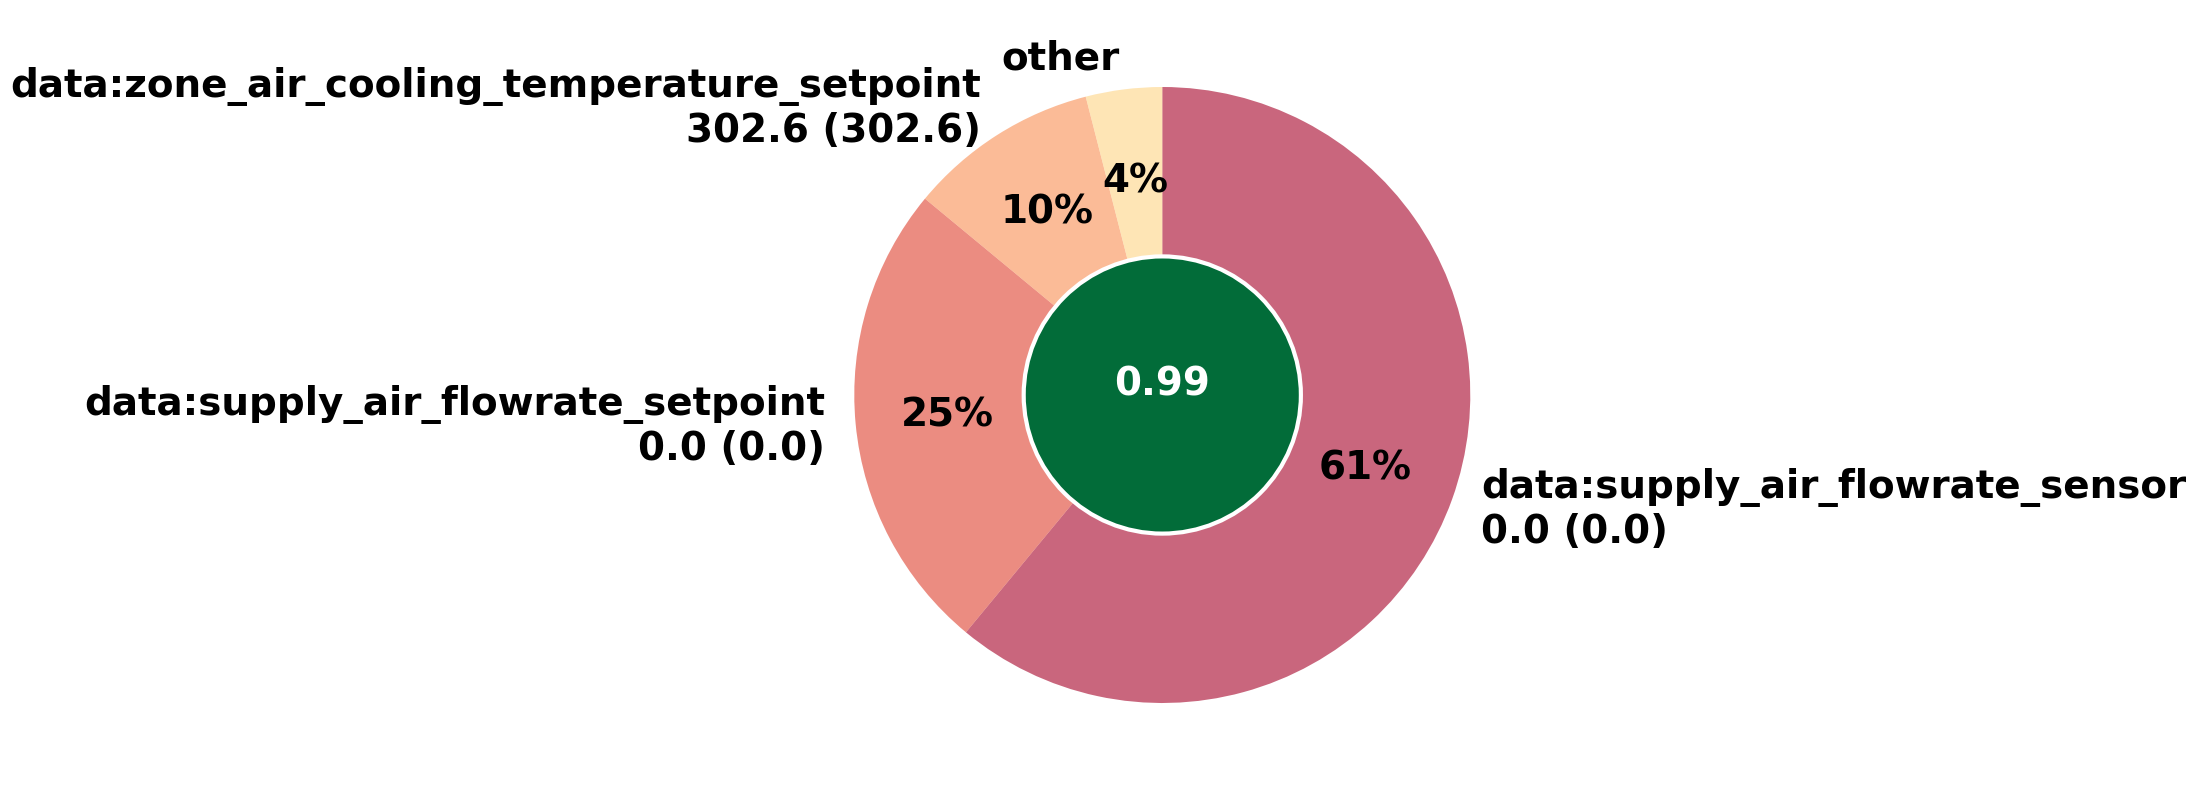

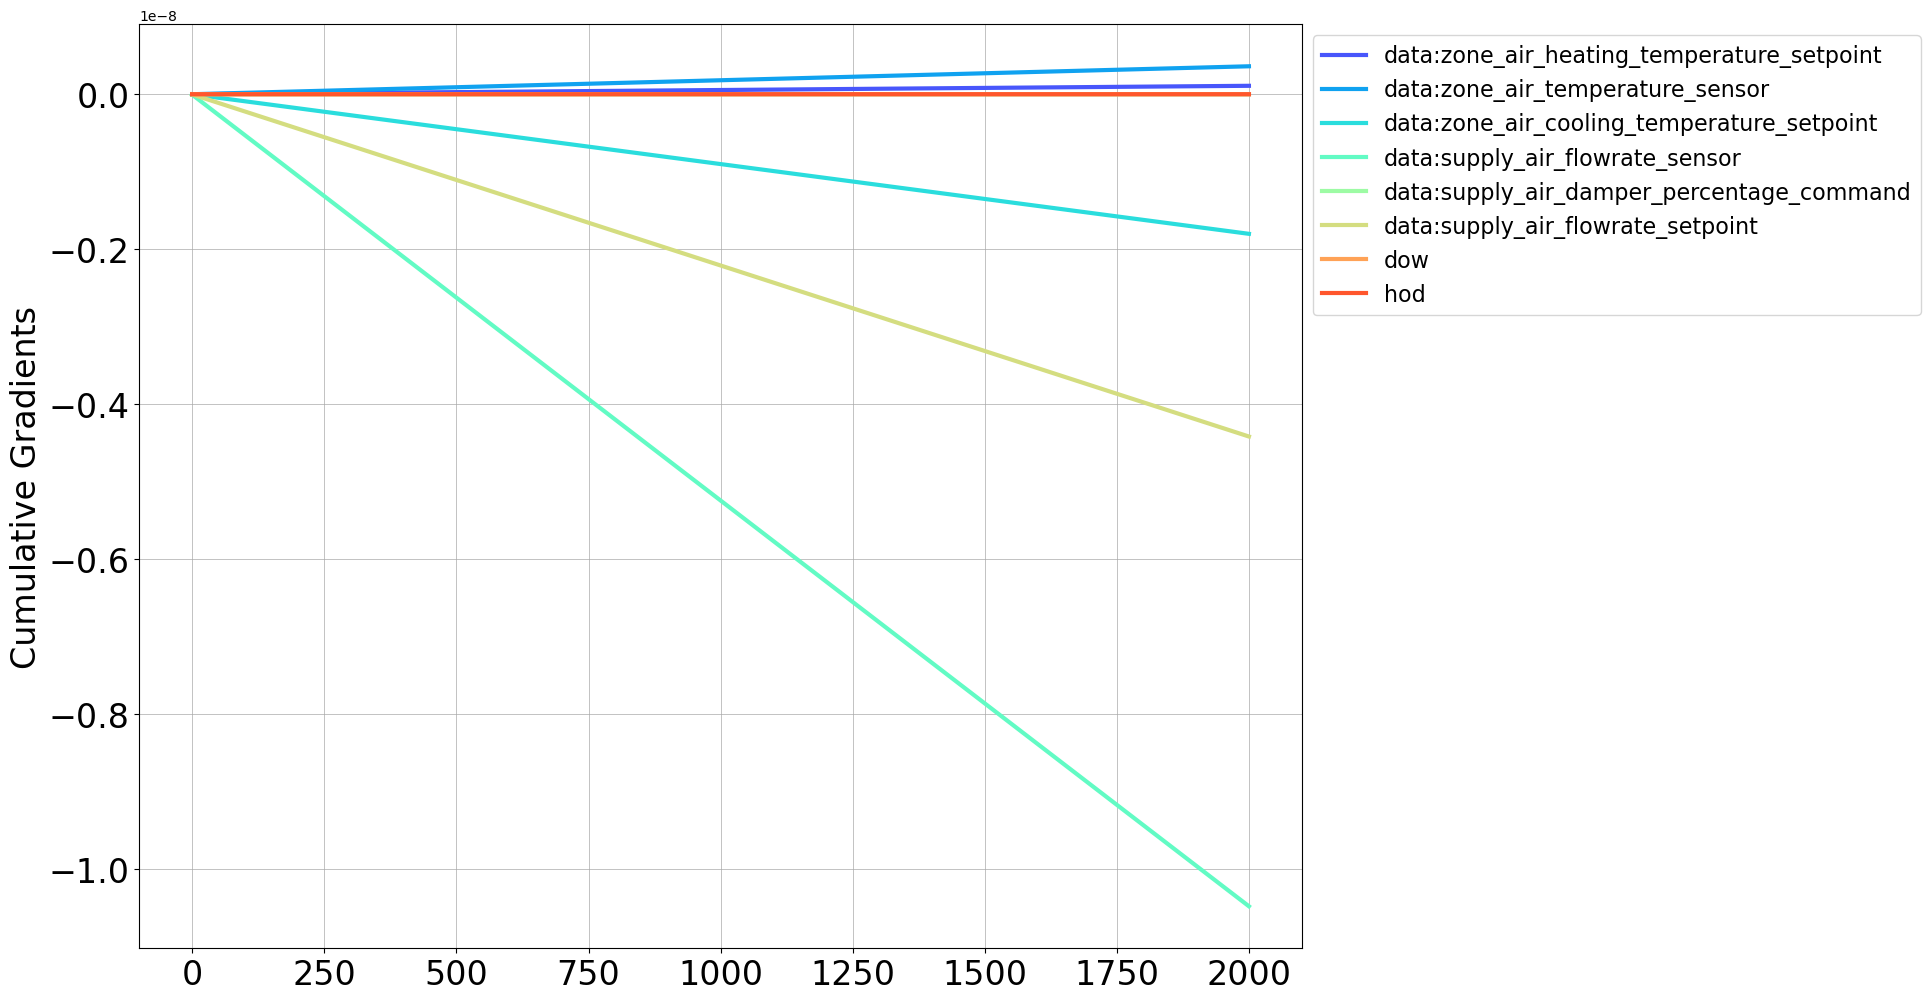

In [7]:
#@title Visualize variable attribution. { vertical-output: false, run: "auto" }

np.set_printoptions(threshold=sys.maxsize)
column_order = madi.utils.sample_utils.get_column_order(ad._normalization_info)
observed_point = {}

################################################################
#vv Copy and paste the text from the cell into the area below.vv
################################################################
print('If you\'re getting an error, please open this cell and paste the output from the last cell here.')
zone_air_heating_temperature_setpoint = 285.925926 #@param {type:"slider", min:250.000000, max:350.000000, step:1.000000}
zone_air_temperature_sensor = 295.148148 #@param {type:"slider", min:250.000000, max:350.000000, step:1.000000}
zone_air_cooling_temperature_setpoint = 302.592593 #@param {type:"slider", min:250.000000, max:350.000000, step:1.000000}
supply_air_flowrate_sensor = 0.000563 #@param {type:"slider", min:-0.522788, max:0.677448, step:0.012002}
supply_air_damper_percentage_command = 99.976080 #@param {type:"slider", min:0.000000, max:100.000000, step:1.000000}
supply_air_flowrate_setpoint = 0.035396 #@param {type:"slider", min:-0.456456, max:0.615860, step:0.010723}
dow = 4.000000 #@param {type:"slider", min:0.000000, max:6.000000, step:1.000000}
hod = 7.000000 #@param {type:"slider", min:0.000000, max:23.000000, step:1.000000}
observed_point['data:zone_air_heating_temperature_setpoint'] = [zone_air_heating_temperature_setpoint]
observed_point['data:zone_air_temperature_sensor'] = [zone_air_temperature_sensor]
observed_point['data:zone_air_cooling_temperature_setpoint'] = [zone_air_cooling_temperature_setpoint]
observed_point['data:supply_air_flowrate_sensor'] = [supply_air_flowrate_sensor]
observed_point['data:supply_air_damper_percentage_command'] = [supply_air_damper_percentage_command]
observed_point['data:supply_air_flowrate_setpoint'] = [supply_air_flowrate_setpoint]
observed_point['dow'] = [dow]
observed_point['hod'] = [hod]
################################################################
#^^ Copy and paste the text from the cell into the area above.^^
################################################################

# Get the observed point from the sliders:
df_observed_point = pd.DataFrame(observed_point)

# Since the sliders are shown in orgininal spaces, we should normalize:
df_observed_point_normalized = madi.utils.sample_utils.normalize(df_observed_point, ad._normalization_info)

# Get the anomaly score from the NSNN.
anomaly_score = ad.predict(df_observed_point.copy())['class_prob'][0]

# Call the Blame method that applies Integrated Gradients.
attribution_dict, reference_point_dict, df_grad = interpreter.blame(df_observed_point_normalized.iloc[0])
attribution = pd.Series(attribution_dict)
nearest_reference_point_normalized = pd.Series(reference_point_dict)
df_nearest_reference_point_normalized = nearest_reference_point_normalized.to_frame().T
df_nearest_reference_point = madi.utils.sample_utils.denormalize(df_nearest_reference_point_normalized, ad._normalization_info)
df_attribution = pd.concat([df_observed_point.iloc[0], df_nearest_reference_point.iloc[0], attribution], axis = 1,
                           keys=['observed_value', 'expected_value', 'attribution'], sort = True)

plot_attribution(df_attribution, anomaly_score)

# Plot the attribution as a cumulative curve from reference to observed.
# Use the normalized difference, b/c the model and its gradients are based on
# normalized training data.
delta_normalized = df_nearest_reference_point_normalized.iloc[0] - df_observed_point_normalized.iloc[0]
colnames  = {}
column_order = madi.utils.sample_utils.get_column_order(ad._normalization_info)
for i in range(len(column_order)):
  colnames[i] = column_order[i]

df_grad.set_axis(column_order, axis=1, inplace=True)
plot_gradient_series(df_grad, delta_normalized)

# TODO(sipple) from review:
# Particularly for smart buildings, it would be cool to have the option to see
# the attributions and the cumulative gradients for an anomaly, something like:
# EXAMPLE_TYPE = 'reference point' #@param ['reference point', 'anomaly']

# if EXAMPLE_TYPE == 'reference point':
#   df_reference_point_selected_normalized = interpreter._df_baseline.sample(1)
#   df_point_selected = madi.utils.sample_utils.denormalize(df_reference_point_selected_normalized, ad._normalization_info)
# elif EXAMPLE_TYPE == 'anomaly':
#   df_point_selected = test_sample[test_sample.class_label == 0].sample(1)
# else:
#   raise NotImplementedError
